In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

In [2]:
import torch
import torch.nn as nn
import numpy as np

In [3]:
ls -lh /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/*.TABLE

-rw-rw-r-- 1 was966 zitnik 116K Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/GENE.TABLE
-rw-rw-r-- 1 was966 zitnik  55K Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/PATIENT.ITRP.TABLE
-rw-rw-r-- 1 was966 zitnik 1.1M Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/PATIENT.TCGA.TABLE
-rw-rw-r-- 1 was966 zitnik  13K Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/pRED.TABLE
-rw-rw-r-- 1 was966 zitnik 2.3M Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/TPM.ITRP.TABLE
-rw-rw-r-- 1 was966 zitnik 4.8M Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/TPM.TCGA.NORMAL.TABLE
-rw-rw-r-- 1 was966 zitnik  69M Oct 12 15:27 /n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/TPM.TCGA.TABLE


In [49]:
def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    return dfd
    
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-MERGE/876/'
df_tpm = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.TABLE'))

tcga_label = pd.read_pickle(os.path.join(data_path, 'PATIENT.TCGA.TABLE'))
mutation = tcga_label[['tmb', 'cnv', 'msi']] #.fillna(0)
df_cancer = tcga_label[['cancer_type']]

df_tmb = mutation[['tmb']]
df_msi = mutation[['msi']]
df_cnv= mutation[['cnv']]
df_ctc = tcga_label[['cancer_type']]

df_msi = onehot(df_msi.msi)
df_ctc = onehot(df_ctc.cancer_type)
df_rps = onehot(tcga_label['treatment_outcome'])
df_ost = np.log10(tcga_label[['os_time']]+1)
df_oss = onehot(tcga_label.os_status)

df_pft = np.log10(tcga_label[['pfi_time']]+1)
df_pfs = onehot(tcga_label.pfi_status)


df_tpm_normal = pd.read_pickle(os.path.join(data_path, 'TPM.TCGA.NORMAL.TABLE'))

In [51]:

tasks = {'msi': df_msi, 
         'tmb': df_tmb, 
         'cnv':df_cnv, 
         'ctc':df_ctc, 
         'rps':df_rps, 
         'ost':df_ost,
         'oss':df_oss,
         'pft':df_pft,
         'pfs':df_pfs}
 
tasks_type_map = {'msi': 'c', 'tmb': 'r', 
                  'cnv':'r', 'ctc':'c', 
                  'rps':'c', 'ost':'r', 
                  'oss':'c', 'pft':'r', 'pfs':'c'}

for task,df_task  in tasks.items():
    task_type = tasks_type_map[task]

In [5]:
import torch.utils.data as data
from data import TCGAData, GeneData

from aug import MixupNomralAugmentor
from data import TCGAData, GeneData
from model import TCGAPretrainModel
from train import predict, train

from loss import TripletLoss, TripletCosineLoss, CEWithNaNLabelsLoss, MSEWithNaNLabelsLoss
from saver import SaveBestModel

from plot import plot_embed_with_label

In [19]:
device='cuda'
lr = 1e-5
weight_decay = 1e-4
epochs = 20
batch_size = 128
embed_dim=32
triplet_margin=1.

## load data
sl_task = 'tmb'
df_task = df_tmb
task_type = 'c'
task_loss_weight = 1.
task_dense_layer = [32, 16]
task_batch_norms = True

encoder='transformer'
transformer_dim = 256
transformer_num_layers = 3

save_dir = './PretrainTCGA_%s_%s' % (encoder, sl_task)

#encoder= 'mlp'
mlp_dense_layers = [1024, 512, 256, 128]

In [6]:

augmentor = MixupNomralAugmentor(df_tpm_normal, df_tpm_normal.columns, beta=0.7)
train_tcga = TCGAData(df_tpm, df_msi, augmentor)
train_loader = data.DataLoader(train_tcga, batch_size=batch_size, shuffle=True,
                                drop_last=True, pin_memory=True, num_workers=4)

input_dim = len(train_tcga.feature_name)
task_dim = train_tcga.y.shape[1]
model = TCGAPretrainModel(input_dim, task_dim, task_type, embed_dim, 
                          encoder = encoder, #
                          mlp_dense_layers = mlp_dense_layers, 
                          transformer_dim = transformer_dim,
                          transformer_num_layers = transformer_num_layers,
                          task_dense_layer = task_dense_layer, 
                          task_batch_norms = task_batch_norms) #transformer_dim = 128, transformer_num_layers = 2

#model = torch.jit.script(model).to(device)
model = model.to(device)

triplet_loss = torch.jit.script(TripletLoss(margin=triplet_margin))
ce_loss = torch.jit.script(CEWithNaNLabelsLoss())
mse_loss = torch.jit.script(MSEWithNaNLabelsLoss())

optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-4, last_epoch=-1)
saver = SaveBestModel(save_dir = save_dir, save_name = 'tcga_best_model.pth')
ssl_loss = triplet_loss
if task_type == 'c':
    tsk_loss = ce_loss
else:
    tsk_loss = mse_loss

In [7]:
performace = []
for epoch in tqdm(range(epochs), desc="Epochs", ascii=True):
    train_total_loss, train_ssl_loss, train_tsk_loss = train(train_loader, model, optimizer, 
                                                             ssl_loss, tsk_loss, device, 
                                                             alpha = task_loss_weight)
    saver(train_total_loss, epoch, model, optimizer)
    performace.append([epoch, train_total_loss, train_ssl_loss, train_tsk_loss])
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, train_total_loss))
saver.save()

Epochs:   0%|          | 1/500 [00:05<43:10,  5.19s/it]

Epoch: 1/500 - Loss: 2.0473


Epochs:   0%|          | 2/500 [00:07<30:16,  3.65s/it]

Epoch: 2/500 - Loss: 1.7935


Epochs:   1%|          | 3/500 [00:10<26:27,  3.19s/it]

Epoch: 3/500 - Loss: 1.9356


Epochs:   1%|          | 4/500 [00:13<25:01,  3.03s/it]

Epoch: 4/500 - Loss: 1.7388


Epochs:   1%|1         | 5/500 [00:15<23:37,  2.86s/it]

Epoch: 5/500 - Loss: 1.8030


Epochs:   1%|1         | 6/500 [00:18<22:40,  2.75s/it]

Epoch: 6/500 - Loss: 1.6175


Epochs:   1%|1         | 7/500 [00:20<21:58,  2.67s/it]

Epoch: 7/500 - Loss: 1.4764


Epochs:   2%|1         | 8/500 [00:22<20:08,  2.46s/it]

Epoch: 8/500 - Loss: 1.4919


Epochs:   2%|1         | 9/500 [00:25<19:53,  2.43s/it]

Epoch: 9/500 - Loss: 1.4193


Epochs:   2%|2         | 10/500 [00:27<19:16,  2.36s/it]

Epoch: 10/500 - Loss: 1.3257


Epochs:   2%|2         | 11/500 [00:29<19:19,  2.37s/it]

Epoch: 11/500 - Loss: 1.3974


Epochs:   2%|2         | 12/500 [00:32<19:55,  2.45s/it]

Epoch: 12/500 - Loss: 1.4335


Epochs:   3%|2         | 13/500 [00:34<19:56,  2.46s/it]

Epoch: 13/500 - Loss: 1.2326


Epochs:   3%|2         | 14/500 [00:37<19:59,  2.47s/it]

Epoch: 14/500 - Loss: 1.2603


Epochs:   3%|3         | 15/500 [00:39<19:43,  2.44s/it]

Epoch: 15/500 - Loss: 1.4153


Epochs:   3%|3         | 16/500 [00:42<19:37,  2.43s/it]

Epoch: 16/500 - Loss: 1.3375


Epochs:   3%|3         | 17/500 [00:44<19:12,  2.39s/it]

Epoch: 17/500 - Loss: 1.3166


Epochs:   4%|3         | 18/500 [00:47<19:47,  2.46s/it]

Epoch: 18/500 - Loss: 1.3019


Epochs:   4%|3         | 19/500 [00:49<19:30,  2.43s/it]

Epoch: 19/500 - Loss: 1.2387


Epochs:   4%|4         | 20/500 [00:52<19:53,  2.49s/it]

Epoch: 20/500 - Loss: 1.2105


Epochs:   4%|4         | 21/500 [00:55<21:27,  2.69s/it]

Epoch: 21/500 - Loss: 1.1800


Epochs:   4%|4         | 22/500 [00:57<21:08,  2.65s/it]

Epoch: 22/500 - Loss: 1.8571


Epochs:   5%|4         | 23/500 [01:00<20:45,  2.61s/it]

Epoch: 23/500 - Loss: 1.4341


Epochs:   5%|4         | 24/500 [01:02<20:31,  2.59s/it]

Epoch: 24/500 - Loss: 1.4071


Epochs:   5%|5         | 25/500 [01:05<19:32,  2.47s/it]

Epoch: 25/500 - Loss: 1.2364


Epochs:   5%|5         | 26/500 [01:07<19:25,  2.46s/it]

Epoch: 26/500 - Loss: 1.2386


Epochs:   5%|5         | 27/500 [01:09<18:22,  2.33s/it]

Epoch: 27/500 - Loss: 1.1384


Epochs:   6%|5         | 28/500 [01:11<18:00,  2.29s/it]

Epoch: 28/500 - Loss: 1.1749


Epochs:   6%|5         | 29/500 [01:14<18:10,  2.31s/it]

Epoch: 29/500 - Loss: 1.0854


Epochs:   6%|6         | 30/500 [01:16<18:22,  2.34s/it]

Epoch: 30/500 - Loss: 1.0585


Epochs:   6%|6         | 31/500 [01:19<18:49,  2.41s/it]

Epoch: 31/500 - Loss: 1.2875


Epochs:   6%|6         | 32/500 [01:21<18:33,  2.38s/it]

Epoch: 32/500 - Loss: 1.3312


Epochs:   7%|6         | 33/500 [01:23<18:21,  2.36s/it]

Epoch: 33/500 - Loss: 1.1497


Epochs:   7%|6         | 34/500 [01:26<19:01,  2.45s/it]

Epoch: 34/500 - Loss: 1.1303


Epochs:   7%|7         | 35/500 [01:28<18:19,  2.36s/it]

Epoch: 35/500 - Loss: 1.1774


Epochs:   7%|7         | 36/500 [01:30<18:37,  2.41s/it]

Epoch: 36/500 - Loss: 1.0174


Epochs:   7%|7         | 37/500 [01:33<18:39,  2.42s/it]

Epoch: 37/500 - Loss: 1.0206


Epochs:   8%|7         | 38/500 [01:36<19:05,  2.48s/it]

Epoch: 38/500 - Loss: 0.9661


Epochs:   8%|7         | 39/500 [01:38<18:45,  2.44s/it]

Epoch: 39/500 - Loss: 1.0673


Epochs:   8%|8         | 40/500 [01:40<19:01,  2.48s/it]

Epoch: 40/500 - Loss: 0.8905


Epochs:   8%|8         | 41/500 [01:43<18:35,  2.43s/it]

Epoch: 41/500 - Loss: 0.8689


Epochs:   8%|8         | 42/500 [01:45<17:52,  2.34s/it]

Epoch: 42/500 - Loss: 0.9317


Epochs:   9%|8         | 43/500 [01:47<17:21,  2.28s/it]

Epoch: 43/500 - Loss: 0.9335


Epochs:   9%|8         | 44/500 [01:49<17:36,  2.32s/it]

Epoch: 44/500 - Loss: 1.0162


Epochs:   9%|9         | 45/500 [01:52<18:14,  2.41s/it]

Epoch: 45/500 - Loss: 1.0753


Epochs:   9%|9         | 46/500 [01:55<18:26,  2.44s/it]

Epoch: 46/500 - Loss: 0.9048


Epochs:   9%|9         | 47/500 [01:57<18:00,  2.38s/it]

Epoch: 47/500 - Loss: 0.9151


Epochs:  10%|9         | 48/500 [01:59<18:04,  2.40s/it]

Epoch: 48/500 - Loss: 0.9228


Epochs:  10%|9         | 49/500 [02:02<17:50,  2.37s/it]

Epoch: 49/500 - Loss: 0.9108


Epochs:  10%|#         | 50/500 [02:04<17:54,  2.39s/it]

Epoch: 50/500 - Loss: 0.8521


Epochs:  10%|#         | 51/500 [02:06<17:52,  2.39s/it]

Epoch: 51/500 - Loss: 0.8811


Epochs:  10%|#         | 52/500 [02:09<18:03,  2.42s/it]

Epoch: 52/500 - Loss: 0.8532


Epochs:  11%|#         | 53/500 [02:11<17:29,  2.35s/it]

Epoch: 53/500 - Loss: 0.8586


Epochs:  11%|#         | 54/500 [02:14<18:03,  2.43s/it]

Epoch: 54/500 - Loss: 0.8473


Epochs:  11%|#1        | 55/500 [02:16<18:38,  2.51s/it]

Epoch: 55/500 - Loss: 0.8801


Epochs:  11%|#1        | 56/500 [02:19<19:00,  2.57s/it]

Epoch: 56/500 - Loss: 0.8669


Epochs:  11%|#1        | 57/500 [02:22<19:23,  2.63s/it]

Epoch: 57/500 - Loss: 0.8331


Epochs:  12%|#1        | 58/500 [02:24<19:14,  2.61s/it]

Epoch: 58/500 - Loss: 0.8514


Epochs:  12%|#1        | 59/500 [02:27<19:14,  2.62s/it]

Epoch: 59/500 - Loss: 0.9291


Epochs:  12%|#2        | 60/500 [02:30<18:48,  2.57s/it]

Epoch: 60/500 - Loss: 0.8919


Epochs:  12%|#2        | 61/500 [02:32<18:36,  2.54s/it]

Epoch: 61/500 - Loss: 0.8618


Epochs:  12%|#2        | 62/500 [02:35<18:39,  2.56s/it]

Epoch: 62/500 - Loss: 0.8309


Epochs:  13%|#2        | 63/500 [02:37<18:00,  2.47s/it]

Epoch: 63/500 - Loss: 0.9009


Epochs:  13%|#2        | 64/500 [02:39<17:44,  2.44s/it]

Epoch: 64/500 - Loss: 0.9189


Epochs:  13%|#3        | 65/500 [02:42<18:12,  2.51s/it]

Epoch: 65/500 - Loss: 0.8773


Epochs:  13%|#3        | 66/500 [02:44<17:06,  2.37s/it]

Epoch: 66/500 - Loss: 0.8472


Epochs:  13%|#3        | 67/500 [02:47<17:50,  2.47s/it]

Epoch: 67/500 - Loss: 0.8314


Epochs:  14%|#3        | 68/500 [02:49<17:50,  2.48s/it]

Epoch: 68/500 - Loss: 0.8467


Epochs:  14%|#3        | 69/500 [02:51<17:27,  2.43s/it]

Epoch: 69/500 - Loss: 0.8319


Epochs:  14%|#4        | 70/500 [02:54<18:11,  2.54s/it]

Epoch: 70/500 - Loss: 0.9022


Epochs:  14%|#4        | 71/500 [02:57<17:59,  2.52s/it]

Epoch: 71/500 - Loss: 0.8570


Epochs:  14%|#4        | 72/500 [02:59<17:31,  2.46s/it]

Epoch: 72/500 - Loss: 0.8865


Epochs:  15%|#4        | 73/500 [03:01<17:06,  2.40s/it]

Epoch: 73/500 - Loss: 0.8677


Epochs:  15%|#4        | 74/500 [03:04<17:44,  2.50s/it]

Epoch: 74/500 - Loss: 0.8859


Epochs:  15%|#5        | 75/500 [03:07<17:47,  2.51s/it]

Epoch: 75/500 - Loss: 0.8798


Epochs:  15%|#5        | 76/500 [03:09<17:28,  2.47s/it]

Epoch: 76/500 - Loss: 0.8299


Epochs:  15%|#5        | 77/500 [03:11<17:21,  2.46s/it]

Epoch: 77/500 - Loss: 0.8252


Epochs:  16%|#5        | 78/500 [03:14<17:28,  2.48s/it]

Epoch: 78/500 - Loss: 0.8322


Epochs:  16%|#5        | 79/500 [03:16<17:23,  2.48s/it]

Epoch: 79/500 - Loss: 0.8296


Epochs:  16%|#6        | 80/500 [03:19<18:05,  2.59s/it]

Epoch: 80/500 - Loss: 0.8651


Epochs:  16%|#6        | 81/500 [03:22<18:13,  2.61s/it]

Epoch: 81/500 - Loss: 0.8297


Epochs:  16%|#6        | 82/500 [03:25<19:35,  2.81s/it]

Epoch: 82/500 - Loss: 0.8479


Epochs:  17%|#6        | 83/500 [03:28<20:20,  2.93s/it]

Epoch: 83/500 - Loss: 0.8539


Epochs:  17%|#6        | 84/500 [03:31<19:06,  2.76s/it]

Epoch: 84/500 - Loss: 0.8411


Epochs:  17%|#7        | 85/500 [03:33<18:12,  2.63s/it]

Epoch: 85/500 - Loss: 0.8219


Epochs:  17%|#7        | 86/500 [03:35<16:51,  2.44s/it]

Epoch: 86/500 - Loss: 0.8203


Epochs:  17%|#7        | 87/500 [03:38<16:46,  2.44s/it]

Epoch: 87/500 - Loss: 0.8616


Epochs:  18%|#7        | 88/500 [03:40<16:38,  2.42s/it]

Epoch: 88/500 - Loss: 0.8206


Epochs:  18%|#7        | 89/500 [03:43<17:16,  2.52s/it]

Epoch: 89/500 - Loss: 0.8241


Epochs:  18%|#8        | 90/500 [03:46<18:17,  2.68s/it]

Epoch: 90/500 - Loss: 0.8390


Epochs:  18%|#8        | 91/500 [03:48<17:46,  2.61s/it]

Epoch: 91/500 - Loss: 0.8323


Epochs:  18%|#8        | 92/500 [03:50<17:04,  2.51s/it]

Epoch: 92/500 - Loss: 0.8174


Epochs:  19%|#8        | 93/500 [03:53<16:20,  2.41s/it]

Epoch: 93/500 - Loss: 0.8128


Epochs:  19%|#8        | 94/500 [03:55<16:16,  2.41s/it]

Epoch: 94/500 - Loss: 0.8127


Epochs:  19%|#9        | 95/500 [03:57<16:21,  2.42s/it]

Epoch: 95/500 - Loss: 0.8323


Epochs:  19%|#9        | 96/500 [04:00<16:23,  2.43s/it]

Epoch: 96/500 - Loss: 0.8726


Epochs:  19%|#9        | 97/500 [04:03<16:59,  2.53s/it]

Epoch: 97/500 - Loss: 0.8327


Epochs:  20%|#9        | 98/500 [04:05<16:44,  2.50s/it]

Epoch: 98/500 - Loss: 0.8193


Epochs:  20%|#9        | 99/500 [04:08<17:00,  2.54s/it]

Epoch: 99/500 - Loss: 0.8147


Epochs:  20%|##        | 100/500 [04:10<15:57,  2.39s/it]

Epoch: 100/500 - Loss: 0.8083


Epochs:  20%|##        | 101/500 [04:12<15:37,  2.35s/it]

Epoch: 101/500 - Loss: 0.8149


Epochs:  20%|##        | 102/500 [04:14<15:31,  2.34s/it]

Epoch: 102/500 - Loss: 0.8087


Epochs:  21%|##        | 103/500 [04:17<16:08,  2.44s/it]

Epoch: 103/500 - Loss: 0.8099


Epochs:  21%|##        | 104/500 [04:20<16:44,  2.54s/it]

Epoch: 104/500 - Loss: 0.8057


Epochs:  21%|##1       | 105/500 [04:22<16:59,  2.58s/it]

Epoch: 105/500 - Loss: 0.8048


Epochs:  21%|##1       | 106/500 [04:25<16:47,  2.56s/it]

Epoch: 106/500 - Loss: 0.8078


Epochs:  21%|##1       | 107/500 [04:28<16:44,  2.56s/it]

Epoch: 107/500 - Loss: 0.8027


Epochs:  22%|##1       | 108/500 [04:30<16:05,  2.46s/it]

Epoch: 108/500 - Loss: 0.8603


Epochs:  22%|##1       | 109/500 [04:33<16:56,  2.60s/it]

Epoch: 109/500 - Loss: 0.9170


Epochs:  22%|##2       | 110/500 [04:35<16:22,  2.52s/it]

Epoch: 110/500 - Loss: 0.9793


Epochs:  22%|##2       | 111/500 [04:38<16:22,  2.53s/it]

Epoch: 111/500 - Loss: 0.8500


Epochs:  22%|##2       | 112/500 [04:40<15:26,  2.39s/it]

Epoch: 112/500 - Loss: 0.8545


Epochs:  23%|##2       | 113/500 [04:42<15:22,  2.38s/it]

Epoch: 113/500 - Loss: 0.8430


Epochs:  23%|##2       | 114/500 [04:44<14:59,  2.33s/it]

Epoch: 114/500 - Loss: 0.8266


Epochs:  23%|##3       | 115/500 [04:46<14:35,  2.27s/it]

Epoch: 115/500 - Loss: 0.8426


Epochs:  23%|##3       | 116/500 [04:49<15:12,  2.38s/it]

Epoch: 116/500 - Loss: 0.8119


Epochs:  23%|##3       | 117/500 [04:51<14:59,  2.35s/it]

Epoch: 117/500 - Loss: 0.8090


Epochs:  24%|##3       | 118/500 [04:54<15:25,  2.42s/it]

Epoch: 118/500 - Loss: 0.8094


Epochs:  24%|##3       | 119/500 [04:57<16:21,  2.58s/it]

Epoch: 119/500 - Loss: 0.8316


Epochs:  24%|##4       | 120/500 [04:59<16:08,  2.55s/it]

Epoch: 120/500 - Loss: 0.8930


Epochs:  24%|##4       | 121/500 [05:02<15:33,  2.46s/it]

Epoch: 121/500 - Loss: 0.8096


Epochs:  24%|##4       | 122/500 [05:05<16:28,  2.62s/it]

Epoch: 122/500 - Loss: 0.8036


Epochs:  25%|##4       | 123/500 [05:07<15:38,  2.49s/it]

Epoch: 123/500 - Loss: 0.8777


Epochs:  25%|##4       | 124/500 [05:09<15:40,  2.50s/it]

Epoch: 124/500 - Loss: 0.8262


Epochs:  25%|##5       | 125/500 [05:12<15:32,  2.49s/it]

Epoch: 125/500 - Loss: 0.8616


Epochs:  25%|##5       | 126/500 [05:14<15:15,  2.45s/it]

Epoch: 126/500 - Loss: 0.8179


Epochs:  25%|##5       | 127/500 [05:17<15:44,  2.53s/it]

Epoch: 127/500 - Loss: 0.8102


Epochs:  26%|##5       | 128/500 [05:19<15:31,  2.50s/it]

Epoch: 128/500 - Loss: 0.8280


Epochs:  26%|##5       | 129/500 [05:22<16:07,  2.61s/it]

Epoch: 129/500 - Loss: 0.8351


Epochs:  26%|##6       | 130/500 [05:24<15:42,  2.55s/it]

Epoch: 130/500 - Loss: 0.8094


Epochs:  26%|##6       | 131/500 [05:27<15:07,  2.46s/it]

Epoch: 131/500 - Loss: 0.8105


Epochs:  26%|##6       | 132/500 [05:29<15:34,  2.54s/it]

Epoch: 132/500 - Loss: 0.8332


Epochs:  27%|##6       | 133/500 [05:31<14:33,  2.38s/it]

Epoch: 133/500 - Loss: 0.8304


Epochs:  27%|##6       | 134/500 [05:34<14:14,  2.33s/it]

Epoch: 134/500 - Loss: 0.8235


Epochs:  27%|##7       | 135/500 [05:36<14:35,  2.40s/it]

Epoch: 135/500 - Loss: 0.8924


Epochs:  27%|##7       | 136/500 [05:39<15:28,  2.55s/it]

Epoch: 136/500 - Loss: 0.8185


Epochs:  27%|##7       | 137/500 [05:42<15:40,  2.59s/it]

Epoch: 137/500 - Loss: 0.8269


Epochs:  28%|##7       | 138/500 [05:44<15:00,  2.49s/it]

Epoch: 138/500 - Loss: 0.8324


Epochs:  28%|##7       | 139/500 [05:48<16:49,  2.80s/it]

Epoch: 139/500 - Loss: 0.8021


Epochs:  28%|##8       | 140/500 [05:50<16:20,  2.72s/it]

Epoch: 140/500 - Loss: 0.7976


Epochs:  28%|##8       | 141/500 [05:53<15:59,  2.67s/it]

Epoch: 141/500 - Loss: 0.7971


Epochs:  28%|##8       | 142/500 [05:55<15:30,  2.60s/it]

Epoch: 142/500 - Loss: 0.7967


Epochs:  29%|##8       | 143/500 [05:58<15:31,  2.61s/it]

Epoch: 143/500 - Loss: 0.7949


Epochs:  29%|##8       | 144/500 [06:00<14:57,  2.52s/it]

Epoch: 144/500 - Loss: 0.7940


Epochs:  29%|##9       | 145/500 [06:02<14:14,  2.41s/it]

Epoch: 145/500 - Loss: 1.0121


Epochs:  29%|##9       | 146/500 [06:06<15:51,  2.69s/it]

Epoch: 146/500 - Loss: 0.8141


Epochs:  29%|##9       | 147/500 [06:08<15:04,  2.56s/it]

Epoch: 147/500 - Loss: 0.8028


Epochs:  30%|##9       | 148/500 [06:11<15:33,  2.65s/it]

Epoch: 148/500 - Loss: 0.8044


Epochs:  30%|##9       | 149/500 [06:13<14:55,  2.55s/it]

Epoch: 149/500 - Loss: 0.7994


Epochs:  30%|###       | 150/500 [06:16<15:04,  2.59s/it]

Epoch: 150/500 - Loss: 0.8680


Epochs:  30%|###       | 151/500 [06:18<14:30,  2.49s/it]

Epoch: 151/500 - Loss: 0.8276


Epochs:  30%|###       | 152/500 [06:20<14:26,  2.49s/it]

Epoch: 152/500 - Loss: 0.8017


Epochs:  31%|###       | 153/500 [06:23<14:38,  2.53s/it]

Epoch: 153/500 - Loss: 0.7953


Epochs:  31%|###       | 154/500 [06:26<14:54,  2.59s/it]

Epoch: 154/500 - Loss: 0.7960


Epochs:  31%|###1      | 155/500 [06:29<15:21,  2.67s/it]

Epoch: 155/500 - Loss: 0.7921


Epochs:  31%|###1      | 156/500 [06:31<14:33,  2.54s/it]

Epoch: 156/500 - Loss: 0.8122


Epochs:  31%|###1      | 157/500 [06:33<14:31,  2.54s/it]

Epoch: 157/500 - Loss: 0.8058


Epochs:  32%|###1      | 158/500 [06:36<14:34,  2.56s/it]

Epoch: 158/500 - Loss: 0.7943


Epochs:  32%|###1      | 159/500 [06:38<14:15,  2.51s/it]

Epoch: 159/500 - Loss: 0.7905


Epochs:  32%|###2      | 160/500 [06:41<13:40,  2.41s/it]

Epoch: 160/500 - Loss: 0.7941


Epochs:  32%|###2      | 161/500 [06:43<13:20,  2.36s/it]

Epoch: 161/500 - Loss: 0.7911


Epochs:  32%|###2      | 162/500 [06:45<13:44,  2.44s/it]

Epoch: 162/500 - Loss: 0.7902


Epochs:  33%|###2      | 163/500 [06:48<14:03,  2.50s/it]

Epoch: 163/500 - Loss: 0.7998


Epochs:  33%|###2      | 164/500 [06:50<13:46,  2.46s/it]

Epoch: 164/500 - Loss: 0.8082


Epochs:  33%|###3      | 165/500 [06:53<13:19,  2.39s/it]

Epoch: 165/500 - Loss: 0.8567


Epochs:  33%|###3      | 166/500 [06:55<12:41,  2.28s/it]

Epoch: 166/500 - Loss: 0.8075


Epochs:  33%|###3      | 167/500 [06:58<13:53,  2.50s/it]

Epoch: 167/500 - Loss: 0.7942


Epochs:  34%|###3      | 168/500 [07:00<13:05,  2.37s/it]

Epoch: 168/500 - Loss: 0.8078


Epochs:  34%|###3      | 169/500 [07:02<12:52,  2.33s/it]

Epoch: 169/500 - Loss: 0.8039


Epochs:  34%|###4      | 170/500 [07:05<13:21,  2.43s/it]

Epoch: 170/500 - Loss: 0.7892


Epochs:  34%|###4      | 171/500 [07:07<13:34,  2.48s/it]

Epoch: 171/500 - Loss: 0.7877


Epochs:  34%|###4      | 172/500 [07:10<13:42,  2.51s/it]

Epoch: 172/500 - Loss: 0.7860


Epochs:  35%|###4      | 173/500 [07:12<13:37,  2.50s/it]

Epoch: 173/500 - Loss: 0.7954


Epochs:  35%|###4      | 174/500 [07:15<13:24,  2.47s/it]

Epoch: 174/500 - Loss: 0.8035


Epochs:  35%|###5      | 175/500 [07:18<14:33,  2.69s/it]

Epoch: 175/500 - Loss: 0.8515


Epochs:  35%|###5      | 176/500 [07:20<13:31,  2.50s/it]

Epoch: 176/500 - Loss: 0.8009


Epochs:  35%|###5      | 177/500 [07:22<13:06,  2.44s/it]

Epoch: 177/500 - Loss: 0.7914


Epochs:  36%|###5      | 178/500 [07:25<13:27,  2.51s/it]

Epoch: 178/500 - Loss: 0.7988


Epochs:  36%|###5      | 179/500 [07:27<13:14,  2.47s/it]

Epoch: 179/500 - Loss: 0.7891


Epochs:  36%|###6      | 180/500 [07:30<13:04,  2.45s/it]

Epoch: 180/500 - Loss: 0.7839


Epochs:  36%|###6      | 181/500 [07:33<13:36,  2.56s/it]

Epoch: 181/500 - Loss: 0.7964


Epochs:  36%|###6      | 182/500 [07:35<13:21,  2.52s/it]

Epoch: 182/500 - Loss: 0.8329


Epochs:  37%|###6      | 183/500 [07:37<12:54,  2.44s/it]

Epoch: 183/500 - Loss: 0.8418


Epochs:  37%|###6      | 184/500 [07:40<12:42,  2.41s/it]

Epoch: 184/500 - Loss: 0.7857


Epochs:  37%|###7      | 185/500 [07:42<12:19,  2.35s/it]

Epoch: 185/500 - Loss: 0.7821


Epochs:  37%|###7      | 186/500 [07:44<12:31,  2.39s/it]

Epoch: 186/500 - Loss: 0.7958


Epochs:  37%|###7      | 187/500 [07:47<13:17,  2.55s/it]

Epoch: 187/500 - Loss: 0.7929


Epochs:  38%|###7      | 188/500 [07:50<13:26,  2.59s/it]

Epoch: 188/500 - Loss: 0.7839


Epochs:  38%|###7      | 189/500 [07:52<13:17,  2.56s/it]

Epoch: 189/500 - Loss: 0.7802


Epochs:  38%|###8      | 190/500 [07:55<12:57,  2.51s/it]

Epoch: 190/500 - Loss: 0.7788


Epochs:  38%|###8      | 191/500 [07:57<12:32,  2.43s/it]

Epoch: 191/500 - Loss: 0.7756


Epochs:  38%|###8      | 192/500 [07:59<11:49,  2.30s/it]

Epoch: 192/500 - Loss: 0.7844


Epochs:  39%|###8      | 193/500 [08:02<12:07,  2.37s/it]

Epoch: 193/500 - Loss: 0.7745


Epochs:  39%|###8      | 194/500 [08:04<12:16,  2.41s/it]

Epoch: 194/500 - Loss: 0.7734


Epochs:  39%|###9      | 195/500 [08:06<12:14,  2.41s/it]

Epoch: 195/500 - Loss: 0.7721


Epochs:  39%|###9      | 196/500 [08:09<12:31,  2.47s/it]

Epoch: 196/500 - Loss: 0.8364


Epochs:  39%|###9      | 197/500 [08:11<12:21,  2.45s/it]

Epoch: 197/500 - Loss: 0.8302


Epochs:  40%|###9      | 198/500 [08:14<12:27,  2.48s/it]

Epoch: 198/500 - Loss: 0.7877


Epochs:  40%|###9      | 199/500 [08:16<12:12,  2.43s/it]

Epoch: 199/500 - Loss: 0.8433


Epochs:  40%|####      | 200/500 [08:19<12:33,  2.51s/it]

Epoch: 200/500 - Loss: 0.7830


Epochs:  40%|####      | 201/500 [08:21<11:56,  2.40s/it]

Epoch: 201/500 - Loss: 0.7751


Epochs:  40%|####      | 202/500 [08:24<12:02,  2.42s/it]

Epoch: 202/500 - Loss: 0.8018


Epochs:  41%|####      | 203/500 [08:26<12:08,  2.45s/it]

Epoch: 203/500 - Loss: 0.8294


Epochs:  41%|####      | 204/500 [08:29<12:16,  2.49s/it]

Epoch: 204/500 - Loss: 0.9372


Epochs:  41%|####1     | 205/500 [08:31<12:07,  2.47s/it]

Epoch: 205/500 - Loss: 0.7964


Epochs:  41%|####1     | 206/500 [08:34<12:01,  2.46s/it]

Epoch: 206/500 - Loss: 0.7841


Epochs:  41%|####1     | 207/500 [08:36<11:30,  2.36s/it]

Epoch: 207/500 - Loss: 0.7730


Epochs:  42%|####1     | 208/500 [08:39<12:35,  2.59s/it]

Epoch: 208/500 - Loss: 0.7798


Epochs:  42%|####1     | 209/500 [08:41<12:18,  2.54s/it]

Epoch: 209/500 - Loss: 0.7948


Epochs:  42%|####2     | 210/500 [08:44<11:54,  2.46s/it]

Epoch: 210/500 - Loss: 0.7775


Epochs:  42%|####2     | 211/500 [08:46<11:34,  2.40s/it]

Epoch: 211/500 - Loss: 0.8107


Epochs:  42%|####2     | 212/500 [08:48<11:41,  2.44s/it]

Epoch: 212/500 - Loss: 0.7799


Epochs:  43%|####2     | 213/500 [08:51<11:44,  2.45s/it]

Epoch: 213/500 - Loss: 0.8435


Epochs:  43%|####2     | 214/500 [08:53<11:34,  2.43s/it]

Epoch: 214/500 - Loss: 0.7774


Epochs:  43%|####3     | 215/500 [08:56<12:39,  2.66s/it]

Epoch: 215/500 - Loss: 0.7927


Epochs:  43%|####3     | 216/500 [08:59<12:38,  2.67s/it]

Epoch: 216/500 - Loss: 0.7806


Epochs:  43%|####3     | 217/500 [09:02<12:47,  2.71s/it]

Epoch: 217/500 - Loss: 0.7729


Epochs:  44%|####3     | 218/500 [09:04<12:18,  2.62s/it]

Epoch: 218/500 - Loss: 0.7707


Epochs:  44%|####3     | 219/500 [09:07<12:46,  2.73s/it]

Epoch: 219/500 - Loss: 0.7706


Epochs:  44%|####4     | 220/500 [09:10<12:58,  2.78s/it]

Epoch: 220/500 - Loss: 0.7638


Epochs:  44%|####4     | 221/500 [09:13<12:39,  2.72s/it]

Epoch: 221/500 - Loss: 0.7635


Epochs:  44%|####4     | 222/500 [09:15<12:13,  2.64s/it]

Epoch: 222/500 - Loss: 0.7651


Epochs:  45%|####4     | 223/500 [09:18<11:58,  2.59s/it]

Epoch: 223/500 - Loss: 0.8288


Epochs:  45%|####4     | 224/500 [09:20<11:40,  2.54s/it]

Epoch: 224/500 - Loss: 0.8231


Epochs:  45%|####5     | 225/500 [09:23<11:37,  2.54s/it]

Epoch: 225/500 - Loss: 0.8143


Epochs:  45%|####5     | 226/500 [09:25<11:55,  2.61s/it]

Epoch: 226/500 - Loss: 0.7702


Epochs:  45%|####5     | 227/500 [09:28<11:47,  2.59s/it]

Epoch: 227/500 - Loss: 0.7743


Epochs:  46%|####5     | 228/500 [09:30<11:39,  2.57s/it]

Epoch: 228/500 - Loss: 0.7826


Epochs:  46%|####5     | 229/500 [09:33<11:31,  2.55s/it]

Epoch: 229/500 - Loss: 0.7778


Epochs:  46%|####6     | 230/500 [09:36<12:05,  2.69s/it]

Epoch: 230/500 - Loss: 0.7650


Epochs:  46%|####6     | 231/500 [09:38<11:39,  2.60s/it]

Epoch: 231/500 - Loss: 0.7681


Epochs:  46%|####6     | 232/500 [09:41<11:13,  2.51s/it]

Epoch: 232/500 - Loss: 0.7763


Epochs:  47%|####6     | 233/500 [09:43<11:11,  2.51s/it]

Epoch: 233/500 - Loss: 0.7711


Epochs:  47%|####6     | 234/500 [09:46<10:53,  2.46s/it]

Epoch: 234/500 - Loss: 0.7611


Epochs:  47%|####6     | 235/500 [09:48<10:47,  2.44s/it]

Epoch: 235/500 - Loss: 0.7581


Epochs:  47%|####7     | 236/500 [09:51<11:01,  2.51s/it]

Epoch: 236/500 - Loss: 0.7561


Epochs:  47%|####7     | 237/500 [09:53<10:37,  2.42s/it]

Epoch: 237/500 - Loss: 0.7578


Epochs:  48%|####7     | 238/500 [09:55<10:31,  2.41s/it]

Epoch: 238/500 - Loss: 0.7589


Epochs:  48%|####7     | 239/500 [09:57<10:09,  2.33s/it]

Epoch: 239/500 - Loss: 0.7667


Epochs:  48%|####8     | 240/500 [10:00<10:20,  2.39s/it]

Epoch: 240/500 - Loss: 0.8733


Epochs:  48%|####8     | 241/500 [10:02<10:07,  2.35s/it]

Epoch: 241/500 - Loss: 0.7760


Epochs:  48%|####8     | 242/500 [10:05<10:12,  2.38s/it]

Epoch: 242/500 - Loss: 0.8347


Epochs:  49%|####8     | 243/500 [10:07<10:13,  2.39s/it]

Epoch: 243/500 - Loss: 0.7816


Epochs:  49%|####8     | 244/500 [10:09<09:54,  2.32s/it]

Epoch: 244/500 - Loss: 0.7585


Epochs:  49%|####9     | 245/500 [10:12<10:18,  2.43s/it]

Epoch: 245/500 - Loss: 0.7622


Epochs:  49%|####9     | 246/500 [10:14<09:58,  2.36s/it]

Epoch: 246/500 - Loss: 0.7531


Epochs:  49%|####9     | 247/500 [10:16<09:35,  2.27s/it]

Epoch: 247/500 - Loss: 0.7598


Epochs:  50%|####9     | 248/500 [10:19<10:08,  2.41s/it]

Epoch: 248/500 - Loss: 0.7544


Epochs:  50%|####9     | 249/500 [10:22<10:48,  2.58s/it]

Epoch: 249/500 - Loss: 0.7498


Epochs:  50%|#####     | 250/500 [10:24<10:23,  2.49s/it]

Epoch: 250/500 - Loss: 0.7528


Epochs:  50%|#####     | 251/500 [10:27<10:21,  2.50s/it]

Epoch: 251/500 - Loss: 0.7502


Epochs:  50%|#####     | 252/500 [10:29<10:10,  2.46s/it]

Epoch: 252/500 - Loss: 0.7479


Epochs:  51%|#####     | 253/500 [10:32<10:30,  2.55s/it]

Epoch: 253/500 - Loss: 0.7730


Epochs:  51%|#####     | 254/500 [10:34<10:19,  2.52s/it]

Epoch: 254/500 - Loss: 0.7609


Epochs:  51%|#####1    | 255/500 [10:36<09:56,  2.43s/it]

Epoch: 255/500 - Loss: 0.7428


Epochs:  51%|#####1    | 256/500 [10:39<10:05,  2.48s/it]

Epoch: 256/500 - Loss: 0.7427


Epochs:  51%|#####1    | 257/500 [10:41<10:01,  2.47s/it]

Epoch: 257/500 - Loss: 0.7566


Epochs:  52%|#####1    | 258/500 [10:44<10:18,  2.56s/it]

Epoch: 258/500 - Loss: 0.7446


Epochs:  52%|#####1    | 259/500 [10:47<10:24,  2.59s/it]

Epoch: 259/500 - Loss: 0.7504


Epochs:  52%|#####2    | 260/500 [10:49<09:53,  2.47s/it]

Epoch: 260/500 - Loss: 0.7676


Epochs:  52%|#####2    | 261/500 [10:51<09:28,  2.38s/it]

Epoch: 261/500 - Loss: 0.7479


Epochs:  52%|#####2    | 262/500 [10:53<09:07,  2.30s/it]

Epoch: 262/500 - Loss: 0.7430


Epochs:  53%|#####2    | 263/500 [10:56<09:21,  2.37s/it]

Epoch: 263/500 - Loss: 0.8101


Epochs:  53%|#####2    | 264/500 [10:58<09:10,  2.33s/it]

Epoch: 264/500 - Loss: 0.7798


Epochs:  53%|#####3    | 265/500 [11:01<09:55,  2.53s/it]

Epoch: 265/500 - Loss: 0.7466


Epochs:  53%|#####3    | 266/500 [11:04<09:46,  2.51s/it]

Epoch: 266/500 - Loss: 0.7392


Epochs:  53%|#####3    | 267/500 [11:06<09:38,  2.48s/it]

Epoch: 267/500 - Loss: 0.7385


Epochs:  54%|#####3    | 268/500 [11:08<09:31,  2.46s/it]

Epoch: 268/500 - Loss: 0.7331


Epochs:  54%|#####3    | 269/500 [11:11<09:06,  2.37s/it]

Epoch: 269/500 - Loss: 0.7379


Epochs:  54%|#####4    | 270/500 [11:13<09:01,  2.35s/it]

Epoch: 270/500 - Loss: 0.7331


Epochs:  54%|#####4    | 271/500 [11:15<08:54,  2.34s/it]

Epoch: 271/500 - Loss: 0.7338


Epochs:  54%|#####4    | 272/500 [11:17<08:28,  2.23s/it]

Epoch: 272/500 - Loss: 0.7308


Epochs:  55%|#####4    | 273/500 [11:20<08:43,  2.31s/it]

Epoch: 273/500 - Loss: 0.7308


Epochs:  55%|#####4    | 274/500 [11:22<08:45,  2.33s/it]

Epoch: 274/500 - Loss: 0.7290


Epochs:  55%|#####5    | 275/500 [11:24<08:50,  2.36s/it]

Epoch: 275/500 - Loss: 0.7308


Epochs:  55%|#####5    | 276/500 [11:27<08:56,  2.40s/it]

Epoch: 276/500 - Loss: 0.7290


Epochs:  55%|#####5    | 277/500 [11:29<08:47,  2.37s/it]

Epoch: 277/500 - Loss: 0.7354


Epochs:  56%|#####5    | 278/500 [11:32<08:38,  2.33s/it]

Epoch: 278/500 - Loss: 0.7542


Epochs:  56%|#####5    | 279/500 [11:34<08:45,  2.38s/it]

Epoch: 279/500 - Loss: 0.7375


Epochs:  56%|#####6    | 280/500 [11:37<08:53,  2.43s/it]

Epoch: 280/500 - Loss: 0.7337


Epochs:  56%|#####6    | 281/500 [11:39<08:49,  2.42s/it]

Epoch: 281/500 - Loss: 0.7268


Epochs:  56%|#####6    | 282/500 [11:41<08:30,  2.34s/it]

Epoch: 282/500 - Loss: 0.7268


Epochs:  57%|#####6    | 283/500 [11:44<08:49,  2.44s/it]

Epoch: 283/500 - Loss: 0.7318


Epochs:  57%|#####6    | 284/500 [11:46<08:39,  2.41s/it]

Epoch: 284/500 - Loss: 0.7350


Epochs:  57%|#####6    | 285/500 [11:48<08:32,  2.39s/it]

Epoch: 285/500 - Loss: 0.7273


Epochs:  57%|#####7    | 286/500 [11:51<08:36,  2.41s/it]

Epoch: 286/500 - Loss: 0.7303


Epochs:  57%|#####7    | 287/500 [11:53<08:38,  2.44s/it]

Epoch: 287/500 - Loss: 0.7264


Epochs:  58%|#####7    | 288/500 [11:55<08:07,  2.30s/it]

Epoch: 288/500 - Loss: 0.7249


Epochs:  58%|#####7    | 289/500 [11:59<09:01,  2.57s/it]

Epoch: 289/500 - Loss: 0.7241


Epochs:  58%|#####8    | 290/500 [12:01<08:48,  2.52s/it]

Epoch: 290/500 - Loss: 0.7254


Epochs:  58%|#####8    | 291/500 [12:04<09:02,  2.60s/it]

Epoch: 291/500 - Loss: 0.7227


Epochs:  58%|#####8    | 292/500 [12:07<09:30,  2.74s/it]

Epoch: 292/500 - Loss: 0.7242


Epochs:  59%|#####8    | 293/500 [12:09<09:04,  2.63s/it]

Epoch: 293/500 - Loss: 0.8043


Epochs:  59%|#####8    | 294/500 [12:11<08:28,  2.47s/it]

Epoch: 294/500 - Loss: 0.7269


Epochs:  59%|#####8    | 295/500 [12:13<08:08,  2.38s/it]

Epoch: 295/500 - Loss: 0.7217


Epochs:  59%|#####9    | 296/500 [12:16<08:10,  2.41s/it]

Epoch: 296/500 - Loss: 0.7230


Epochs:  59%|#####9    | 297/500 [12:19<08:39,  2.56s/it]

Epoch: 297/500 - Loss: 0.7173


Epochs:  60%|#####9    | 298/500 [12:21<08:26,  2.51s/it]

Epoch: 298/500 - Loss: 0.7189


Epochs:  60%|#####9    | 299/500 [12:24<08:21,  2.50s/it]

Epoch: 299/500 - Loss: 0.7145


Epochs:  60%|######    | 300/500 [12:26<08:12,  2.46s/it]

Epoch: 300/500 - Loss: 0.7137


Epochs:  60%|######    | 301/500 [12:29<08:10,  2.47s/it]

Epoch: 301/500 - Loss: 0.7171


Epochs:  60%|######    | 302/500 [12:31<08:13,  2.49s/it]

Epoch: 302/500 - Loss: 0.8567


Epochs:  61%|######    | 303/500 [12:34<08:12,  2.50s/it]

Epoch: 303/500 - Loss: 0.8195


Epochs:  61%|######    | 304/500 [12:36<08:09,  2.50s/it]

Epoch: 304/500 - Loss: 0.7451


Epochs:  61%|######1   | 305/500 [12:39<08:14,  2.54s/it]

Epoch: 305/500 - Loss: 0.7420


Epochs:  61%|######1   | 306/500 [12:41<08:03,  2.49s/it]

Epoch: 306/500 - Loss: 0.7274


Epochs:  61%|######1   | 307/500 [12:44<08:14,  2.56s/it]

Epoch: 307/500 - Loss: 0.7148


Epochs:  62%|######1   | 308/500 [12:46<08:05,  2.53s/it]

Epoch: 308/500 - Loss: 0.7548


Epochs:  62%|######1   | 309/500 [12:49<07:56,  2.49s/it]

Epoch: 309/500 - Loss: 0.7321


Epochs:  62%|######2   | 310/500 [12:51<07:43,  2.44s/it]

Epoch: 310/500 - Loss: 0.7482


Epochs:  62%|######2   | 311/500 [12:53<07:31,  2.39s/it]

Epoch: 311/500 - Loss: 0.7276


Epochs:  62%|######2   | 312/500 [12:56<07:32,  2.41s/it]

Epoch: 312/500 - Loss: 0.7169


Epochs:  63%|######2   | 313/500 [12:58<07:41,  2.47s/it]

Epoch: 313/500 - Loss: 0.7089


Epochs:  63%|######2   | 314/500 [13:01<07:51,  2.54s/it]

Epoch: 314/500 - Loss: 0.7082


Epochs:  63%|######3   | 315/500 [13:04<07:58,  2.58s/it]

Epoch: 315/500 - Loss: 0.7702


Epochs:  63%|######3   | 316/500 [13:06<08:00,  2.61s/it]

Epoch: 316/500 - Loss: 0.7434


Epochs:  63%|######3   | 317/500 [13:09<07:38,  2.51s/it]

Epoch: 317/500 - Loss: 0.7162


Epochs:  64%|######3   | 318/500 [13:12<07:52,  2.60s/it]

Epoch: 318/500 - Loss: 0.7148


Epochs:  64%|######3   | 319/500 [13:14<07:44,  2.57s/it]

Epoch: 319/500 - Loss: 0.7591


Epochs:  64%|######4   | 320/500 [13:16<07:13,  2.41s/it]

Epoch: 320/500 - Loss: 0.7336


Epochs:  64%|######4   | 321/500 [13:18<07:05,  2.38s/it]

Epoch: 321/500 - Loss: 0.7203


Epochs:  64%|######4   | 322/500 [13:21<07:02,  2.37s/it]

Epoch: 322/500 - Loss: 0.7170


Epochs:  65%|######4   | 323/500 [13:24<07:24,  2.51s/it]

Epoch: 323/500 - Loss: 0.7077


Epochs:  65%|######4   | 324/500 [13:26<07:22,  2.51s/it]

Epoch: 324/500 - Loss: 0.7065


Epochs:  65%|######5   | 325/500 [13:28<07:10,  2.46s/it]

Epoch: 325/500 - Loss: 0.7186


Epochs:  65%|######5   | 326/500 [13:31<06:52,  2.37s/it]

Epoch: 326/500 - Loss: 0.7058


Epochs:  65%|######5   | 327/500 [13:33<06:43,  2.33s/it]

Epoch: 327/500 - Loss: 0.7023


Epochs:  66%|######5   | 328/500 [13:35<06:45,  2.36s/it]

Epoch: 328/500 - Loss: 0.7025


Epochs:  66%|######5   | 329/500 [13:38<06:40,  2.34s/it]

Epoch: 329/500 - Loss: 0.7174


Epochs:  66%|######6   | 330/500 [13:40<06:37,  2.34s/it]

Epoch: 330/500 - Loss: 0.7207


Epochs:  66%|######6   | 331/500 [13:42<06:33,  2.33s/it]

Epoch: 331/500 - Loss: 0.7071


Epochs:  66%|######6   | 332/500 [13:44<06:16,  2.24s/it]

Epoch: 332/500 - Loss: 0.7183


Epochs:  67%|######6   | 333/500 [13:47<06:27,  2.32s/it]

Epoch: 333/500 - Loss: 0.7049


Epochs:  67%|######6   | 334/500 [13:49<06:19,  2.29s/it]

Epoch: 334/500 - Loss: 0.7044


Epochs:  67%|######7   | 335/500 [13:51<06:20,  2.31s/it]

Epoch: 335/500 - Loss: 0.6986


Epochs:  67%|######7   | 336/500 [13:54<06:21,  2.32s/it]

Epoch: 336/500 - Loss: 0.6958


Epochs:  67%|######7   | 337/500 [13:56<06:10,  2.27s/it]

Epoch: 337/500 - Loss: 0.6964


Epochs:  68%|######7   | 338/500 [13:58<06:18,  2.34s/it]

Epoch: 338/500 - Loss: 0.7014


Epochs:  68%|######7   | 339/500 [14:00<06:02,  2.25s/it]

Epoch: 339/500 - Loss: 0.7133


Epochs:  68%|######8   | 340/500 [14:03<06:14,  2.34s/it]

Epoch: 340/500 - Loss: 0.6981


Epochs:  68%|######8   | 341/500 [14:05<06:08,  2.32s/it]

Epoch: 341/500 - Loss: 0.7017


Epochs:  68%|######8   | 342/500 [14:07<05:48,  2.21s/it]

Epoch: 342/500 - Loss: 0.6971


Epochs:  69%|######8   | 343/500 [14:10<06:04,  2.32s/it]

Epoch: 343/500 - Loss: 0.6978


Epochs:  69%|######8   | 344/500 [14:12<05:58,  2.30s/it]

Epoch: 344/500 - Loss: 0.7382


Epochs:  69%|######9   | 345/500 [14:15<06:18,  2.44s/it]

Epoch: 345/500 - Loss: 0.7633


Epochs:  69%|######9   | 346/500 [14:17<06:03,  2.36s/it]

Epoch: 346/500 - Loss: 0.7333


Epochs:  69%|######9   | 347/500 [14:19<05:58,  2.34s/it]

Epoch: 347/500 - Loss: 0.7638


Epochs:  70%|######9   | 348/500 [14:22<06:00,  2.37s/it]

Epoch: 348/500 - Loss: 0.7092


Epochs:  70%|######9   | 349/500 [14:24<05:50,  2.32s/it]

Epoch: 349/500 - Loss: 0.7040


Epochs:  70%|#######   | 350/500 [14:26<05:54,  2.36s/it]

Epoch: 350/500 - Loss: 0.7151


Epochs:  70%|#######   | 351/500 [14:28<05:43,  2.31s/it]

Epoch: 351/500 - Loss: 0.7558


Epochs:  70%|#######   | 352/500 [14:31<05:53,  2.39s/it]

Epoch: 352/500 - Loss: 0.7282


Epochs:  71%|#######   | 353/500 [14:33<05:52,  2.39s/it]

Epoch: 353/500 - Loss: 0.7115


Epochs:  71%|#######   | 354/500 [14:36<05:49,  2.39s/it]

Epoch: 354/500 - Loss: 0.7085


Epochs:  71%|#######1  | 355/500 [14:38<05:44,  2.37s/it]

Epoch: 355/500 - Loss: 0.7008


Epochs:  71%|#######1  | 356/500 [14:40<05:32,  2.31s/it]

Epoch: 356/500 - Loss: 0.6925


Epochs:  71%|#######1  | 357/500 [14:43<05:29,  2.31s/it]

Epoch: 357/500 - Loss: 0.6897


Epochs:  72%|#######1  | 358/500 [14:45<05:20,  2.26s/it]

Epoch: 358/500 - Loss: 0.6902


Epochs:  72%|#######1  | 359/500 [14:47<05:35,  2.38s/it]

Epoch: 359/500 - Loss: 0.6882


Epochs:  72%|#######2  | 360/500 [14:49<05:14,  2.25s/it]

Epoch: 360/500 - Loss: 0.7317


Epochs:  72%|#######2  | 361/500 [14:52<05:22,  2.32s/it]

Epoch: 361/500 - Loss: 0.6924


Epochs:  72%|#######2  | 362/500 [14:54<05:10,  2.25s/it]

Epoch: 362/500 - Loss: 0.6957


Epochs:  73%|#######2  | 363/500 [14:56<05:14,  2.30s/it]

Epoch: 363/500 - Loss: 0.7156


Epochs:  73%|#######2  | 364/500 [14:59<05:15,  2.32s/it]

Epoch: 364/500 - Loss: 0.7015


Epochs:  73%|#######3  | 365/500 [15:01<05:19,  2.37s/it]

Epoch: 365/500 - Loss: 0.6932


Epochs:  73%|#######3  | 366/500 [15:04<05:16,  2.36s/it]

Epoch: 366/500 - Loss: 0.6928


Epochs:  73%|#######3  | 367/500 [15:06<05:22,  2.43s/it]

Epoch: 367/500 - Loss: 0.6999


Epochs:  74%|#######3  | 368/500 [15:09<05:24,  2.46s/it]

Epoch: 368/500 - Loss: 0.6907


Epochs:  74%|#######3  | 369/500 [15:11<05:28,  2.51s/it]

Epoch: 369/500 - Loss: 0.7134


Epochs:  74%|#######4  | 370/500 [15:14<05:18,  2.45s/it]

Epoch: 370/500 - Loss: 0.7776


Epochs:  74%|#######4  | 371/500 [15:16<05:15,  2.44s/it]

Epoch: 371/500 - Loss: 0.7195


Epochs:  74%|#######4  | 372/500 [15:18<05:05,  2.38s/it]

Epoch: 372/500 - Loss: 0.7408


Epochs:  75%|#######4  | 373/500 [15:20<04:53,  2.31s/it]

Epoch: 373/500 - Loss: 0.6936


Epochs:  75%|#######4  | 374/500 [15:23<05:05,  2.42s/it]

Epoch: 374/500 - Loss: 0.6938


Epochs:  75%|#######5  | 375/500 [15:26<05:13,  2.51s/it]

Epoch: 375/500 - Loss: 0.7190


Epochs:  75%|#######5  | 376/500 [15:28<05:01,  2.43s/it]

Epoch: 376/500 - Loss: 0.7163


Epochs:  75%|#######5  | 377/500 [15:31<05:06,  2.49s/it]

Epoch: 377/500 - Loss: 0.6959


Epochs:  76%|#######5  | 378/500 [15:33<04:46,  2.35s/it]

Epoch: 378/500 - Loss: 0.6877


Epochs:  76%|#######5  | 379/500 [15:35<04:39,  2.31s/it]

Epoch: 379/500 - Loss: 0.6847


Epochs:  76%|#######6  | 380/500 [15:37<04:46,  2.38s/it]

Epoch: 380/500 - Loss: 0.6876


Epochs:  76%|#######6  | 381/500 [15:40<04:40,  2.35s/it]

Epoch: 381/500 - Loss: 0.6868


Epochs:  76%|#######6  | 382/500 [15:42<04:31,  2.30s/it]

Epoch: 382/500 - Loss: 0.6882


Epochs:  77%|#######6  | 383/500 [15:44<04:30,  2.31s/it]

Epoch: 383/500 - Loss: 0.6827


Epochs:  77%|#######6  | 384/500 [15:47<04:33,  2.36s/it]

Epoch: 384/500 - Loss: 0.6845


Epochs:  77%|#######7  | 385/500 [15:49<04:37,  2.42s/it]

Epoch: 385/500 - Loss: 0.6855


Epochs:  77%|#######7  | 386/500 [15:52<04:36,  2.43s/it]

Epoch: 386/500 - Loss: 0.6858


Epochs:  77%|#######7  | 387/500 [15:54<04:31,  2.40s/it]

Epoch: 387/500 - Loss: 0.6827


Epochs:  78%|#######7  | 388/500 [15:56<04:28,  2.40s/it]

Epoch: 388/500 - Loss: 0.6826


Epochs:  78%|#######7  | 389/500 [15:59<04:34,  2.47s/it]

Epoch: 389/500 - Loss: 0.6833


Epochs:  78%|#######8  | 390/500 [16:01<04:19,  2.36s/it]

Epoch: 390/500 - Loss: 0.6822


Epochs:  78%|#######8  | 391/500 [16:04<04:20,  2.39s/it]

Epoch: 391/500 - Loss: 0.6857


Epochs:  78%|#######8  | 392/500 [16:06<04:21,  2.42s/it]

Epoch: 392/500 - Loss: 0.7601


Epochs:  79%|#######8  | 393/500 [16:09<04:20,  2.43s/it]

Epoch: 393/500 - Loss: 0.7566


Epochs:  79%|#######8  | 394/500 [16:11<04:18,  2.44s/it]

Epoch: 394/500 - Loss: 0.6958


Epochs:  79%|#######9  | 395/500 [16:14<04:19,  2.48s/it]

Epoch: 395/500 - Loss: 0.6915


Epochs:  79%|#######9  | 396/500 [16:16<04:19,  2.49s/it]

Epoch: 396/500 - Loss: 0.6974


Epochs:  79%|#######9  | 397/500 [16:19<04:11,  2.44s/it]

Epoch: 397/500 - Loss: 0.6834


Epochs:  80%|#######9  | 398/500 [16:21<04:18,  2.54s/it]

Epoch: 398/500 - Loss: 0.7257


Epochs:  80%|#######9  | 399/500 [16:24<04:20,  2.58s/it]

Epoch: 399/500 - Loss: 0.6961


Epochs:  80%|########  | 400/500 [16:26<04:07,  2.47s/it]

Epoch: 400/500 - Loss: 0.6939


Epochs:  80%|########  | 401/500 [16:29<04:08,  2.51s/it]

Epoch: 401/500 - Loss: 0.6872


Epochs:  80%|########  | 402/500 [16:31<03:59,  2.45s/it]

Epoch: 402/500 - Loss: 0.6781


Epochs:  81%|########  | 403/500 [16:34<04:03,  2.51s/it]

Epoch: 403/500 - Loss: 0.6796


Epochs:  81%|########  | 404/500 [16:37<04:18,  2.69s/it]

Epoch: 404/500 - Loss: 0.6795


Epochs:  81%|########1 | 405/500 [16:39<04:07,  2.61s/it]

Epoch: 405/500 - Loss: 0.6787


Epochs:  81%|########1 | 406/500 [16:41<03:53,  2.48s/it]

Epoch: 406/500 - Loss: 0.6891


Epochs:  81%|########1 | 407/500 [16:44<03:43,  2.40s/it]

Epoch: 407/500 - Loss: 0.7295


Epochs:  82%|########1 | 408/500 [16:46<03:42,  2.41s/it]

Epoch: 408/500 - Loss: 0.6853


Epochs:  82%|########1 | 409/500 [16:48<03:30,  2.31s/it]

Epoch: 409/500 - Loss: 0.6810


Epochs:  82%|########2 | 410/500 [16:51<03:28,  2.32s/it]

Epoch: 410/500 - Loss: 0.6787


Epochs:  82%|########2 | 411/500 [16:53<03:24,  2.29s/it]

Epoch: 411/500 - Loss: 0.6897


Epochs:  82%|########2 | 412/500 [16:55<03:25,  2.34s/it]

Epoch: 412/500 - Loss: 0.7068


Epochs:  83%|########2 | 413/500 [16:58<03:27,  2.38s/it]

Epoch: 413/500 - Loss: 0.8580


Epochs:  83%|########2 | 414/500 [17:00<03:18,  2.30s/it]

Epoch: 414/500 - Loss: 0.6934


Epochs:  83%|########2 | 415/500 [17:02<03:12,  2.26s/it]

Epoch: 415/500 - Loss: 0.6836


Epochs:  83%|########3 | 416/500 [17:04<02:59,  2.14s/it]

Epoch: 416/500 - Loss: 0.6793


Epochs:  83%|########3 | 417/500 [17:06<03:10,  2.30s/it]

Epoch: 417/500 - Loss: 0.6752


Epochs:  84%|########3 | 418/500 [17:09<03:11,  2.34s/it]

Epoch: 418/500 - Loss: 0.6758


Epochs:  84%|########3 | 419/500 [17:11<03:14,  2.40s/it]

Epoch: 419/500 - Loss: 0.6816


Epochs:  84%|########4 | 420/500 [17:14<03:18,  2.48s/it]

Epoch: 420/500 - Loss: 0.6784


Epochs:  84%|########4 | 421/500 [17:16<03:08,  2.38s/it]

Epoch: 421/500 - Loss: 0.6756


Epochs:  84%|########4 | 422/500 [17:19<03:08,  2.41s/it]

Epoch: 422/500 - Loss: 0.6755


Epochs:  85%|########4 | 423/500 [17:22<03:22,  2.63s/it]

Epoch: 423/500 - Loss: 0.6783


Epochs:  85%|########4 | 424/500 [17:24<03:11,  2.51s/it]

Epoch: 424/500 - Loss: 0.6770


Epochs:  85%|########5 | 425/500 [17:27<03:05,  2.47s/it]

Epoch: 425/500 - Loss: 0.6779


Epochs:  85%|########5 | 426/500 [17:29<02:52,  2.33s/it]

Epoch: 426/500 - Loss: 0.6999


Epochs:  85%|########5 | 427/500 [17:31<02:44,  2.25s/it]

Epoch: 427/500 - Loss: 0.6860


Epochs:  86%|########5 | 428/500 [17:33<02:40,  2.22s/it]

Epoch: 428/500 - Loss: 0.7369


Epochs:  86%|########5 | 429/500 [17:35<02:38,  2.24s/it]

Epoch: 429/500 - Loss: 0.8062


Epochs:  86%|########6 | 430/500 [17:37<02:36,  2.23s/it]

Epoch: 430/500 - Loss: 0.7175


Epochs:  86%|########6 | 431/500 [17:39<02:28,  2.15s/it]

Epoch: 431/500 - Loss: 0.6836


Epochs:  86%|########6 | 432/500 [17:42<02:32,  2.24s/it]

Epoch: 432/500 - Loss: 0.6755


Epochs:  87%|########6 | 433/500 [17:44<02:34,  2.31s/it]

Epoch: 433/500 - Loss: 0.6777


Epochs:  87%|########6 | 434/500 [17:47<02:39,  2.42s/it]

Epoch: 434/500 - Loss: 0.6755


Epochs:  87%|########7 | 435/500 [17:49<02:31,  2.34s/it]

Epoch: 435/500 - Loss: 0.6732


Epochs:  87%|########7 | 436/500 [17:51<02:28,  2.32s/it]

Epoch: 436/500 - Loss: 0.7373


Epochs:  87%|########7 | 437/500 [17:54<02:32,  2.41s/it]

Epoch: 437/500 - Loss: 0.6901


Epochs:  88%|########7 | 438/500 [17:57<02:34,  2.49s/it]

Epoch: 438/500 - Loss: 0.6794


Epochs:  88%|########7 | 439/500 [17:59<02:29,  2.46s/it]

Epoch: 439/500 - Loss: 0.6730


Epochs:  88%|########8 | 440/500 [18:01<02:28,  2.47s/it]

Epoch: 440/500 - Loss: 0.6729


Epochs:  88%|########8 | 441/500 [18:04<02:21,  2.40s/it]

Epoch: 441/500 - Loss: 0.6741


Epochs:  88%|########8 | 442/500 [18:06<02:11,  2.27s/it]

Epoch: 442/500 - Loss: 0.6745


Epochs:  89%|########8 | 443/500 [18:08<02:08,  2.26s/it]

Epoch: 443/500 - Loss: 0.6734


Epochs:  89%|########8 | 444/500 [18:10<02:04,  2.21s/it]

Epoch: 444/500 - Loss: 0.6726


Epochs:  89%|########9 | 445/500 [18:12<01:57,  2.13s/it]

Epoch: 445/500 - Loss: 0.6735


Epochs:  89%|########9 | 446/500 [18:14<01:58,  2.19s/it]

Epoch: 446/500 - Loss: 0.6737


Epochs:  89%|########9 | 447/500 [18:16<01:52,  2.13s/it]

Epoch: 447/500 - Loss: 0.6762


Epochs:  90%|########9 | 448/500 [18:18<01:50,  2.12s/it]

Epoch: 448/500 - Loss: 0.6719


Epochs:  90%|########9 | 449/500 [18:21<01:50,  2.17s/it]

Epoch: 449/500 - Loss: 0.6738


Epochs:  90%|######### | 450/500 [18:23<01:49,  2.20s/it]

Epoch: 450/500 - Loss: 0.6916


Epochs:  90%|######### | 451/500 [18:25<01:47,  2.20s/it]

Epoch: 451/500 - Loss: 0.6911


Epochs:  90%|######### | 452/500 [18:28<01:53,  2.37s/it]

Epoch: 452/500 - Loss: 0.6803


Epochs:  91%|######### | 453/500 [18:30<01:47,  2.29s/it]

Epoch: 453/500 - Loss: 0.6779


Epochs:  91%|######### | 454/500 [18:32<01:47,  2.33s/it]

Epoch: 454/500 - Loss: 0.6738


Epochs:  91%|#########1| 455/500 [18:35<01:45,  2.35s/it]

Epoch: 455/500 - Loss: 0.6805


Epochs:  91%|#########1| 456/500 [18:37<01:40,  2.29s/it]

Epoch: 456/500 - Loss: 0.7308


Epochs:  91%|#########1| 457/500 [18:39<01:34,  2.20s/it]

Epoch: 457/500 - Loss: 0.7582


Epochs:  92%|#########1| 458/500 [18:42<01:40,  2.40s/it]

Epoch: 458/500 - Loss: 0.6860


Epochs:  92%|#########1| 459/500 [18:44<01:40,  2.46s/it]

Epoch: 459/500 - Loss: 0.7086


Epochs:  92%|#########2| 460/500 [18:47<01:39,  2.48s/it]

Epoch: 460/500 - Loss: 0.6741


Epochs:  92%|#########2| 461/500 [18:50<01:38,  2.53s/it]

Epoch: 461/500 - Loss: 0.6708


Epochs:  92%|#########2| 462/500 [18:52<01:38,  2.60s/it]

Epoch: 462/500 - Loss: 0.6679


Epochs:  93%|#########2| 463/500 [18:55<01:32,  2.50s/it]

Epoch: 463/500 - Loss: 0.6696


Epochs:  93%|#########2| 464/500 [18:57<01:29,  2.50s/it]

Epoch: 464/500 - Loss: 0.6680


Epochs:  93%|#########3| 465/500 [19:00<01:27,  2.51s/it]

Epoch: 465/500 - Loss: 0.7014


Epochs:  93%|#########3| 466/500 [19:02<01:24,  2.49s/it]

Epoch: 466/500 - Loss: 0.6780


Epochs:  93%|#########3| 467/500 [19:05<01:24,  2.57s/it]

Epoch: 467/500 - Loss: 0.7017


Epochs:  94%|#########3| 468/500 [19:07<01:23,  2.60s/it]

Epoch: 468/500 - Loss: 0.6803


Epochs:  94%|#########3| 469/500 [19:10<01:18,  2.52s/it]

Epoch: 469/500 - Loss: 0.6730


Epochs:  94%|#########3| 470/500 [19:12<01:15,  2.53s/it]

Epoch: 470/500 - Loss: 0.6731


Epochs:  94%|#########4| 471/500 [19:15<01:12,  2.50s/it]

Epoch: 471/500 - Loss: 0.6709


Epochs:  94%|#########4| 472/500 [19:17<01:07,  2.40s/it]

Epoch: 472/500 - Loss: 0.6953


Epochs:  95%|#########4| 473/500 [19:19<01:05,  2.43s/it]

Epoch: 473/500 - Loss: 0.6773


Epochs:  95%|#########4| 474/500 [19:22<01:02,  2.41s/it]

Epoch: 474/500 - Loss: 0.7045


Epochs:  95%|#########5| 475/500 [19:25<01:02,  2.49s/it]

Epoch: 475/500 - Loss: 0.6810


Epochs:  95%|#########5| 476/500 [19:27<00:57,  2.38s/it]

Epoch: 476/500 - Loss: 0.6893


Epochs:  95%|#########5| 477/500 [19:29<00:55,  2.41s/it]

Epoch: 477/500 - Loss: 0.6834


Epochs:  96%|#########5| 478/500 [19:32<00:54,  2.47s/it]

Epoch: 478/500 - Loss: 0.6734


Epochs:  96%|#########5| 479/500 [19:34<00:52,  2.49s/it]

Epoch: 479/500 - Loss: 0.6695


Epochs:  96%|#########6| 480/500 [19:37<00:49,  2.49s/it]

Epoch: 480/500 - Loss: 0.6682


Epochs:  96%|#########6| 481/500 [19:39<00:46,  2.47s/it]

Epoch: 481/500 - Loss: 0.6691


Epochs:  96%|#########6| 482/500 [19:42<00:44,  2.49s/it]

Epoch: 482/500 - Loss: 0.6657


Epochs:  97%|#########6| 483/500 [19:44<00:42,  2.51s/it]

Epoch: 483/500 - Loss: 0.6682


Epochs:  97%|#########6| 484/500 [19:47<00:40,  2.51s/it]

Epoch: 484/500 - Loss: 0.6677


Epochs:  97%|#########7| 485/500 [19:49<00:36,  2.41s/it]

Epoch: 485/500 - Loss: 0.6657


Epochs:  97%|#########7| 486/500 [19:51<00:33,  2.42s/it]

Epoch: 486/500 - Loss: 0.6669


Epochs:  97%|#########7| 487/500 [19:54<00:32,  2.53s/it]

Epoch: 487/500 - Loss: 0.6675


Epochs:  98%|#########7| 488/500 [19:56<00:29,  2.46s/it]

Epoch: 488/500 - Loss: 0.6658


Epochs:  98%|#########7| 489/500 [19:59<00:26,  2.40s/it]

Epoch: 489/500 - Loss: 0.7311


Epochs:  98%|#########8| 490/500 [20:01<00:23,  2.31s/it]

Epoch: 490/500 - Loss: 0.6775


Epochs:  98%|#########8| 491/500 [20:03<00:20,  2.32s/it]

Epoch: 491/500 - Loss: 0.6713


Epochs:  98%|#########8| 492/500 [20:06<00:19,  2.43s/it]

Epoch: 492/500 - Loss: 0.6662


Epochs:  99%|#########8| 493/500 [20:08<00:17,  2.46s/it]

Epoch: 493/500 - Loss: 0.6703


Epochs:  99%|#########8| 494/500 [20:11<00:14,  2.46s/it]

Epoch: 494/500 - Loss: 0.7968


Epochs:  99%|#########9| 495/500 [20:13<00:12,  2.42s/it]

Epoch: 495/500 - Loss: 0.7010


Epochs:  99%|#########9| 496/500 [20:15<00:09,  2.38s/it]

Epoch: 496/500 - Loss: 0.6827


Epochs:  99%|#########9| 497/500 [20:18<00:07,  2.37s/it]

Epoch: 497/500 - Loss: 0.6935


Epochs: 100%|#########9| 498/500 [20:20<00:04,  2.35s/it]

Epoch: 498/500 - Loss: 0.6676


Epochs: 100%|#########9| 499/500 [20:23<00:02,  2.42s/it]

Epoch: 499/500 - Loss: 0.6700


Epochs: 100%|##########| 500/500 [20:25<00:00,  2.45s/it]

Epoch: 500/500 - Loss: 0.7035
Saving final model...

Best validation loss: 0.6656566262245178

Saving best model on epoch: 482



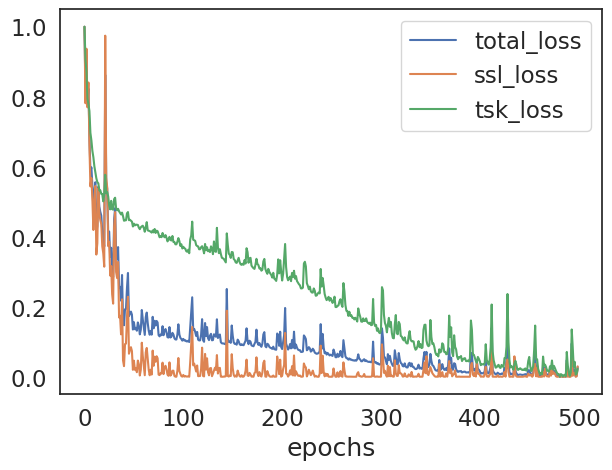

In [27]:
df = pd.DataFrame(performace, columns = ['epochs', 'total_loss', 'ssl_loss', 'tsk_loss']).set_index('epochs')
v = (df - df.min(axis=0)) / (df.max(axis=0) - df.min(axis=0))
fig, ax = plt.subplots(figsize=(7,5))
v.plot(ax = ax)
fig.savefig(os.path.join(save_dir, 'tcga_train_loss.png'), bbox_inches='tight')
df.to_pickle(os.path.join(save_dir, 'tcga_train_loss.pkl'))

<Axes: xlabel='epochs'>

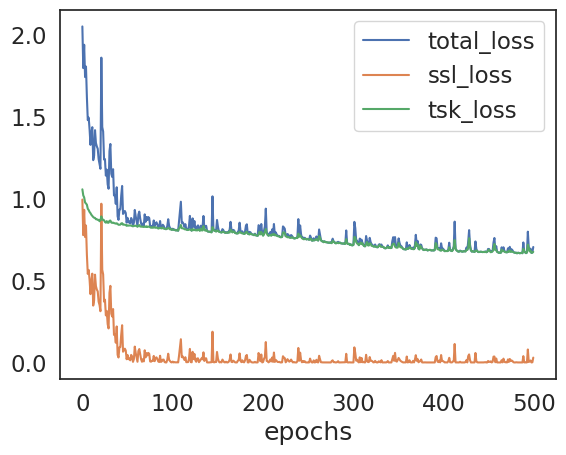

In [9]:
df.plot()

In [10]:
### for make prediction
model = TCGAPretrainModel(**saver.inMemorySave['model_args']) #transformer_dim = 128, transformer_num_layers = 2
model.load_state_dict(saver.inMemorySave['model_state_dict'])

dfe, dfp = predict(df_tpm, model,  device='cpu')

/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/distanc

UMAP(random_state=42, spread=5, verbose=1)
Fri Oct 13 16:13:15 2023 Construct fuzzy simplicial set
Fri Oct 13 16:13:15 2023 Finding Nearest Neighbors
Fri Oct 13 16:13:15 2023 Building RP forest with 10 trees
Fri Oct 13 16:13:18 2023 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	Stopping threshold met -- exiting after 3 iterations
Fri Oct 13 16:13:36 2023 Finished Nearest Neighbor Search
Fri Oct 13 16:13:38 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Oct 13 16:13:48 2023 Finished embedding


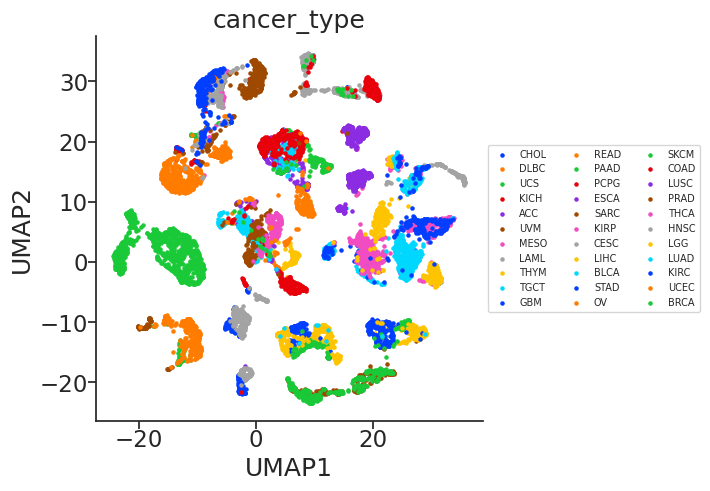

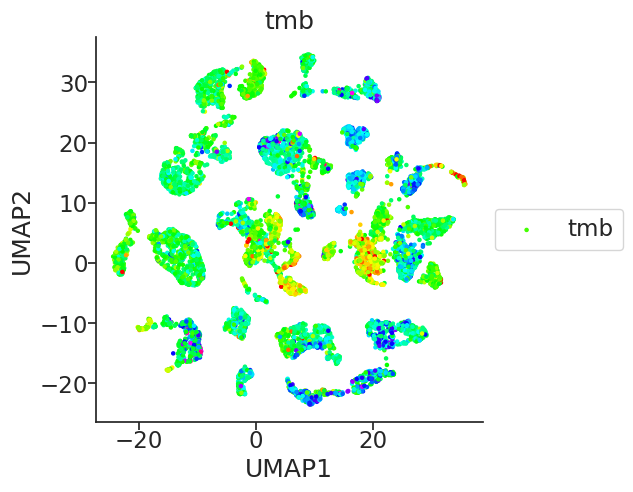

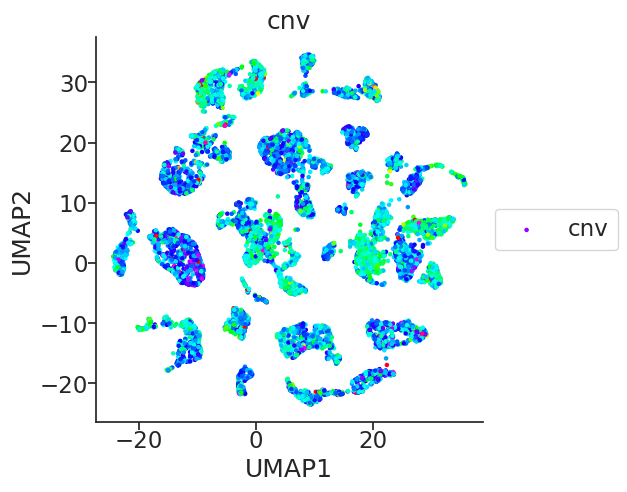

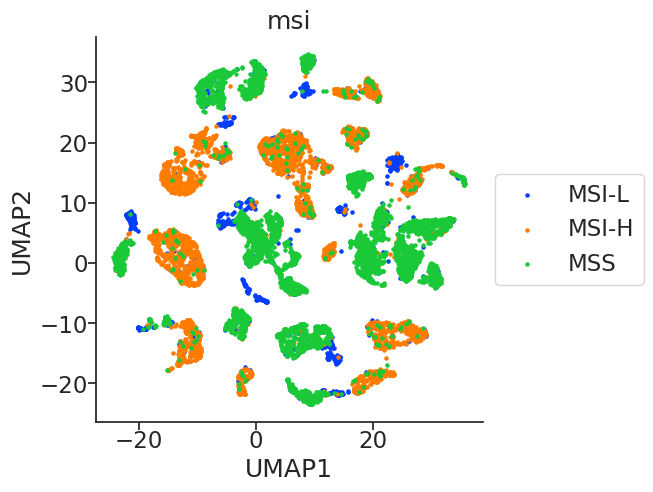

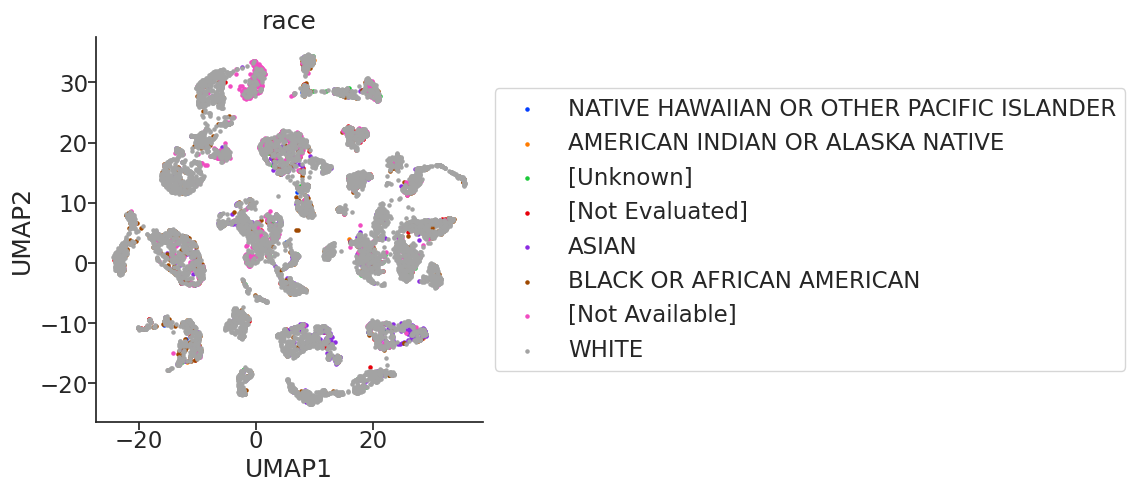

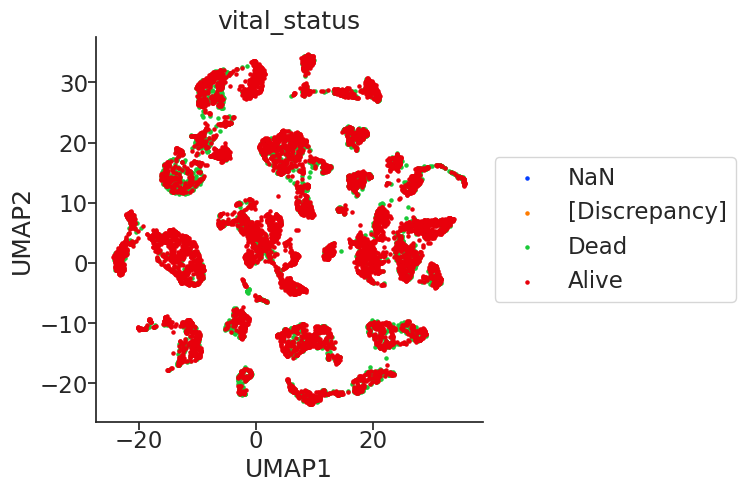

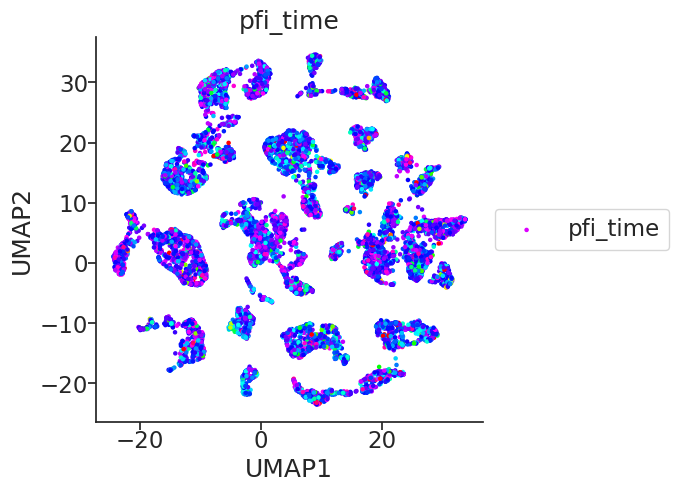

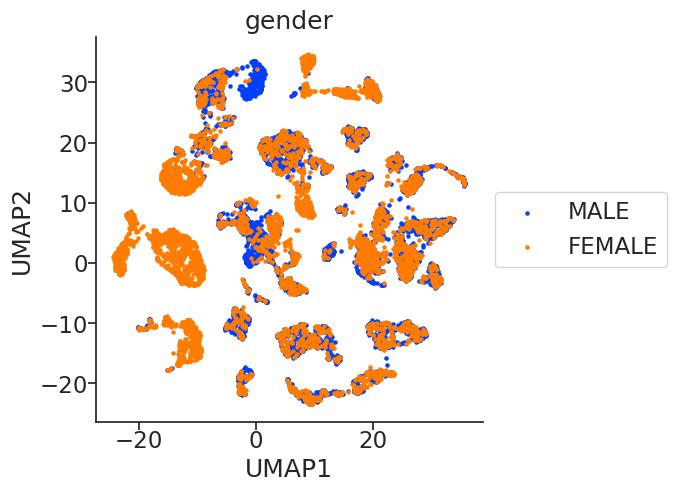

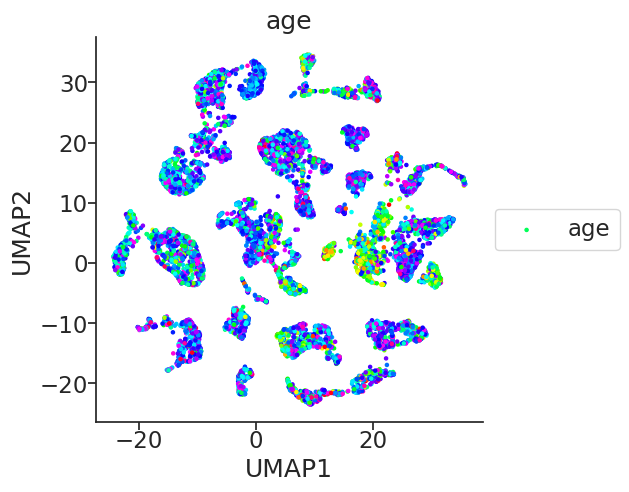

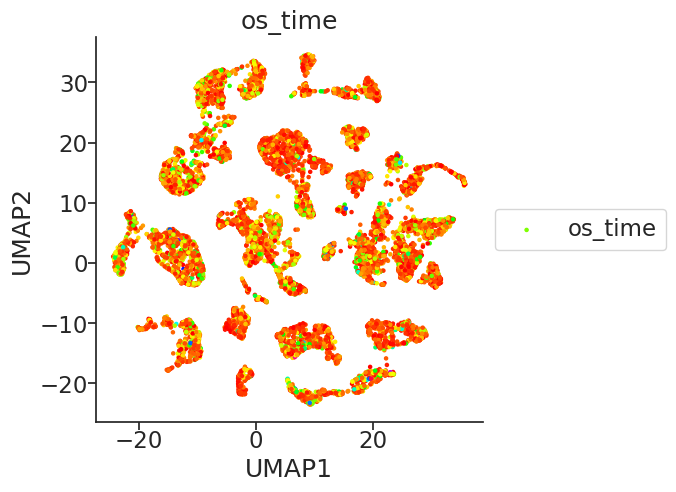

In [13]:

dfc = df_cancer.cancer_type.apply(lambda x:x.replace('TCGA-', ''))
msi = tcga_label[['msi']]
cnv = tcga_label.cnv.clip(-1, 0.5).to_frame(name='cnv')

l1 = tcga_label[['race', 'vital_status']].fillna('NaN')
l2 = np.log10(tcga_label[['pfi_time']]+1)
l3 = tcga_label[['gender', 'age', 'os_time']]

dfd = dfe.join(dfc).join(df_tmb).join(cnv).join(msi).join(l1).join(l2).join(l3)

label_col = ['cancer_type', 'tmb', 'cnv', 'msi','race', 'vital_status','pfi_time', 'gender', 'age', 'os_time']
label_type = ['c', 'r', 'r', 'c','c', 'c', 'r',  'c', 'r', 'r']
figs = plot_embed_with_label(dfd, n_neighbors=15, spread=5,
                             label_col = label_col,  
                             label_type = label_type, figsize=(5,5))

for fig, name in zip(figs, label_col):
    fig.savefig(os.path.join(save_dir, 'tcga_%s.png' % name), bbox_inches='tight', )

# Downstream Tasks

In [14]:
itrp_x = pd.read_pickle(os.path.join(data_path, 'TPM.ITRP.TABLE'))
itrp_meta = pd.read_pickle(os.path.join(data_path, 'PATIENT.ITRP.TABLE'))
itrp_meta['response_label'] = itrp_meta['Freeman_response']
itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']

itrp_y = itrp_meta[['response_label']]
itrp_c = itrp_meta[['cohort']]
itrp_meta.groupby('cohort')['response_label'].value_counts().unstack().T

itrp_dfe, itrp_dfp = predict(itrp_x, model,  device='cpu')

/tmp/ipykernel_6950/2228403688.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itrp_meta['response_label'][itrp_meta.cohort == 'Gide'] = itrp_meta['RECIST_Response'][itrp_meta.cohort == 'Gide']


UMAP(random_state=42, spread=5, verbose=1)
Fri Oct 13 16:15:43 2023 Construct fuzzy simplicial set
Fri Oct 13 16:15:44 2023 Finding Nearest Neighbors
Fri Oct 13 16:15:44 2023 Finished Nearest Neighbor Search
Fri Oct 13 16:15:44 2023 Construct embedding


/home/was966/micromamba/envs/RNA/lib/python3.11/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


Epochs completed:   0%|            0/500 [00:00]

Fri Oct 13 16:15:45 2023 Finished embedding


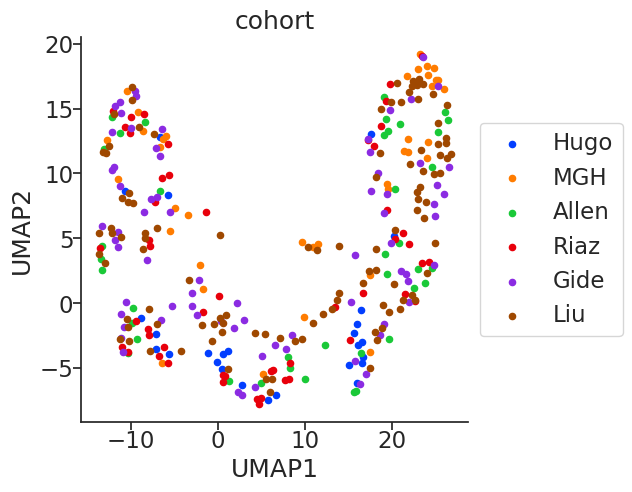

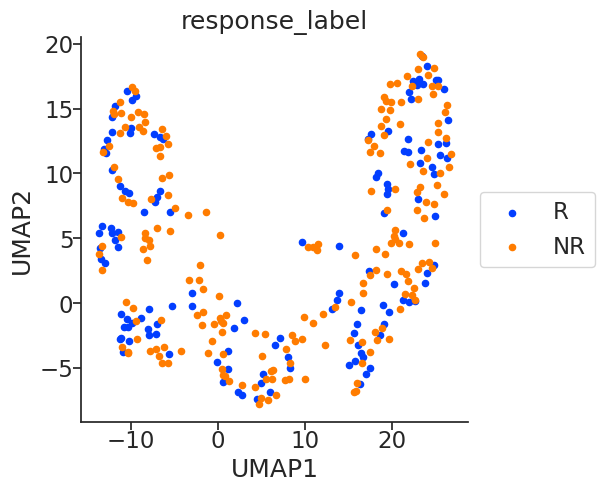

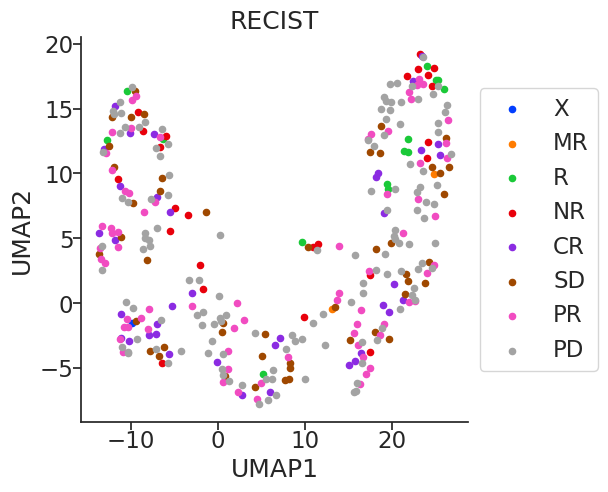

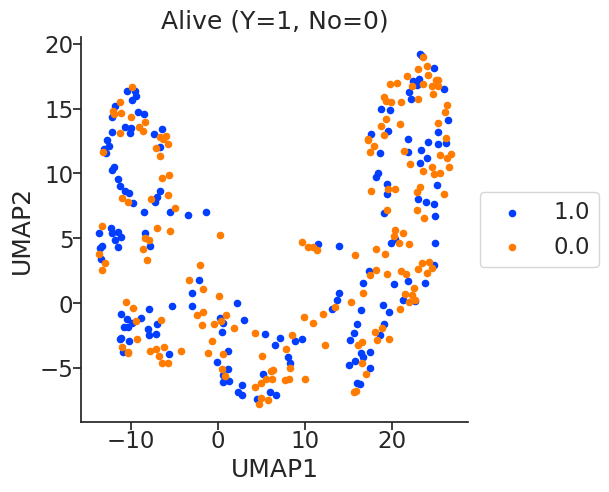

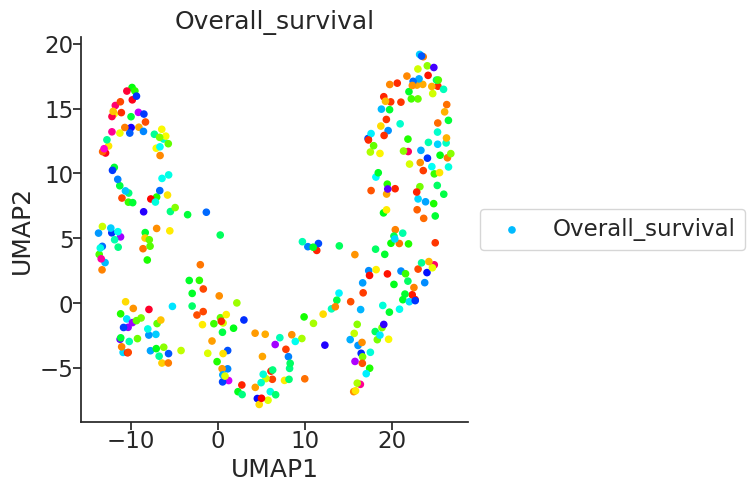

In [16]:
label_col = ['cohort','response_label','RECIST','Alive (Y=1, No=0)', 'Overall_survival']
label_type = ['c', 'c', 'c', 'c', 'r']

dfd = itrp_dfe.join(itrp_meta[cols])

figs = plot_embed_with_label(dfd, n_neighbors=15,
                            spread=5,
                            s=20,
                             label_col = label_col,  
                             label_type = label_type, figsize=(5,5))


for fig, name in zip(figs, label_col):
    fig.savefig(os.path.join(save_dir, 'itrp_%s.png' % name), bbox_inches='tight', )